# Publication List for A Researcher in Bibtex Format
Fetch publications of a specific person identified by his/her ORCID ID, and export as bibtex format file. Visualise data in different ways to get more insights.

[Download Notebook](https://github.com/researchgraph/augment-api-beta/blob/main/docs/notebooks/publications.ipynb)

Related Notebooks:  
- [orcid notebook](./orcid.ipynb) Query Researcher and Co-author Relationships by ORCID  
- [doi notebook](./doi.ipynb) Query Data by DOI    
- [affiliations notebook](./affiliations.ipynb) Query Researcher and Affiliations by ORCID. Mapping affiliation data on worldmap, visualising researcher-organisation relationship.



In [1]:
import sys
sys.path.append('../')

# Packages for plotting charts, graphs and wordcloud
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS 

# Packages for data manipulation
import pandas as pd
from datetime import datetime, date

# Packages to use API
import requests
import json

# packages to read API_KEY
import os
from os.path import join, dirname
from dotenv import load_dotenv
load_dotenv();

## API Errors  
When using the API, we load API_KEY and ORCID ID you want to search into variables and add them in the url string. Later the python request package will pass those values to the API and get the data you want. This section shows the 2 types of common errors you might get when using augment API. Either the ORCID id passed is invalid or the API_KEY is not load successfully from you environment file.
### ORCID ID Not Found  
Here we assign an invalid value to the ORCID variable. When error occurs, the request.get( ) will be an object with the status code indicating what type error it is with an error message for explanation.

In [2]:
# ORCID ID not found
API_KEY = os.environ.get("API_KEY")
ORCID = "0000-0003-XXXX-XXXX"

url = f'https://augmentapi.researchgraph.com/v1/orcid/{ORCID}?subscription-key={API_KEY}'
r = requests.get(url)

# print a short confirmation on completion
print('Augment API query complete ', r.status_code)

if r.status_code == 400:
    print(r.json()[0]["error"])

Augment API query complete  400
We have failed to identify this ORCID (0000-0003-XXXX-XXXX). If it is a new identifier, it might take a few days to appear on our server.


### Missing API_KEY  
You will receive an authentication error if the API KEY in not valid.

In [3]:
# Missing API_KEY
API_KEY = ''
ORCID = "0000-0002-0715-6126"

url = f'https://augmentapi.researchgraph.com/v1/orcid/{ORCID}?subscription-key={API_KEY}'
r = requests.get(url)

# print a short confirmation on completion
print('Augment API query complete ', r.status_code)

if r.status_code == 401:
    print(f'Authentication error.', r.json()['message'])

Augment API query complete  401
Authentication error. Access denied due to invalid subscription key. Make sure to provide a valid key for an active subscription.


## Data Extraction for Valid ORCID ID  
For valid ORCID records retrieved, it is a nested dictionary structure with all data that is connected to the ORCID requested. First level has 3 keys as shown in the block below.

In [4]:
# ORCID ID does exist
API_KEY = os.environ.get("API_KEY")
ORCID = "0000-0002-0068-716X"

url = f'https://augmentapi.researchgraph.com/v1/orcid/{ORCID}?subscription-key={API_KEY}'
r = requests.get(url)

# print a short confirmation on completion
print('Augment API query complete ', r.status_code)

# Shows data 
print('The data returned has below fields: ',r.json()[0].keys())

Augment API query complete  200
The data returned has below fields:  dict_keys(['nodes', 'relationships', 'stats'])


In nodes, data is stored for 5 labels as the researchgraph schema:

In [5]:
r.json()[0]["nodes"].keys()

dict_keys(['datasets', 'grants', 'organisations', 'publications', 'researchers'])

Each data above is stored as a list of dictionaries. To extract the data we need, iterate through the list and check for the ORCID.

In [6]:
# ORCID ID does exist
API_KEY = os.environ.get("API_KEY")
ORCID = "0000-0002-0068-716X"

url = f'https://augmentapi.researchgraph.com/v1/orcid/{ORCID}?subscription-key={API_KEY}'
r = requests.get(url)

# print a short confirmation on completion
print('Augment API query complete ', r.status_code)

if r.status_code == 200 and r.json()[0]["nodes"]["researchers"]:    
    researchers = r.json()[0]["nodes"]["researchers"]
    
    researcher = None
    for i in range(len(researchers)):
        if researchers[i]["orcid"] == ORCID:
            researcher = researchers[i]

print()
print(f'ORCID: {researcher["orcid"]}')
print(f'First name: {researcher["first_name"]}')
print(f'Last name: {researcher["last_name"]}')
print()
print(f'The researcher {researcher["full_name"]} is connected to {r.json()[0]["stats"]}.')

Augment API query complete  200

ORCID: 0000-0002-0068-716X
First name: Cameron
Last name: Neylon

The researcher Cameron Neylon is connected to {'datasets': 18, 'grants': 9, 'organisations': 245, 'publications': 149, 'researchers': 152}.


### List of publications as bibtex
Only includes publications with DOIs, and duplicate Titles removed, sorted by publication year in descending order

In [7]:
# include all publications
pd.set_option("display.max_rows", None)

df = pd.DataFrame(r.json()[0]["nodes"]["publications"], columns=['doi', 'publication_year', 'title'])
df = df.dropna()
df = df.drop_duplicates(subset=['title'])
df = df.sort_values(by=['publication_year','doi'], ascending=False)

In [8]:
# Use crossref API to get bibtex foramt data
data = []
for index, row in df.iterrows():
    url = f'http://dx.doi.org/{row["doi"]}'
    headers = {'Accept': 'text/bibliography', 'style': 'bibtex'}
    ra = requests.get(url, headers=headers)
    print(f'Crosscite API query for {row["doi"]} complete', ra.status_code,)
    data.append(ra.text)

bib = '\n'.join(data)
# Export data into a bib document
with open(researcher['last_name'].lower() + '_publications.bib', 'a') as fp:
    fp.write(bib)

Crosscite API query for 10.54900/rhk5f9d-nj4c28m-cefpz complete 200
Crosscite API query for 10.16995/olh.4809 complete 200
Crosscite API query for 10.13003/XDVU4372 complete 200
Crosscite API query for 10.7717/peerj.11391 complete 200
Crosscite API query for 10.5281/zenodo.4893802 complete 200
Crosscite API query for 10.5281/zenodo.4680985 complete 200
Crosscite API query for 10.5281/zenodo.4663353 complete 200
Crosscite API query for 10.1629/uksg.558 complete 200
Crosscite API query for 10.1007/978-3-030-71305-8_36 complete 200
Crosscite API query for 10.7554/elife.57067.sa2 complete 200
Crosscite API query for 10.7554/elife.57067 complete 200
Crosscite API query for 10.6084/m9.figshare.13010000.v1 complete 200
Crosscite API query for 10.6084/m9.figshare.13010000 complete 200
Crosscite API query for 10.5281/zenodo.5842028 complete 200
Crosscite API query for 10.5281/zenodo.4040402 complete 200
Crosscite API query for 10.5281/zenodo.3620965 complete 200
Crosscite API query for 10.4000/

### Publications by year

We can also get publication trend by counting the publication records each year. Below code also handling years without any publications. Using the ResearchGraph color for publications.

In [9]:
plot_title = alt.TitleParams(f'{researcher["full_name"]} (ORCID {ORCID})', subtitle=['Publications by Year'])
alt.Chart(df, title=plot_title).mark_bar(color='#49B1F4').properties(width=500).encode(
    x=alt.X("publication_year:O", axis=alt.Axis(title='Publication Year', labelAngle=0, labelSeparation=10)),
    y=alt.Y("count:Q", impute=alt.ImputeParams(value=0, keyvals={"start": int(min(df['publication_year'].tolist())), "stop": datetime.now().year }), axis=alt.Axis(title=None))
).transform_aggregate(
    count='count(publication_year)',
    groupby=["publication_year"]
).configure_title(
    fontSize=18
).configure_axis(
    grid=False
).configure_view(
    strokeWidth=0
)

alt.Chart(...)

### Topics of publications  
If we want to know the topic by keywords in all publications by this researcher, we can create a wordcloud for the data too.

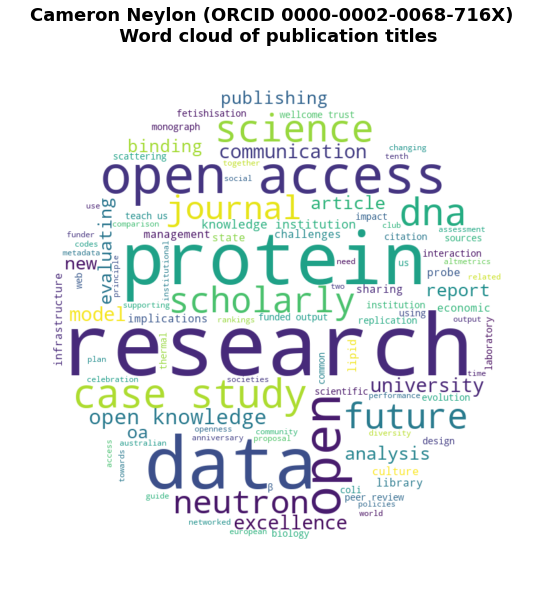

In [10]:
# High frequency meaningless words to be removed, e.g. the, a, of...
stopWords = set(STOPWORDS)
stopWords.add('_')

titleWords=[]
for index, row in df.iterrows():
    tokens = [t.lower() for t in row['title'].split()]     
    titleWords += tokens
     
x, y = np.ogrid[:800, :800]
mask = (x - 400) ** 2 + (y - 400) ** 2 > 345 ** 2
mask = 255 * mask.astype(int)
    
wordcloud = WordCloud(width = 600, height = 600,
            max_words = 100,
            background_color ='white', 
            stopwords = stopWords, 
            min_font_size = 12, 
            mask = mask).generate(" ".join(titleWords))
    
fig, ax = plt.subplots(1, 1, figsize = (8, 8), facecolor = None)
ax.set_title(f'{researcher["full_name"]} (ORCID {researcher["orcid"]}) \n Word cloud of publication titles', fontsize=18, fontweight="semibold")
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()